In [75]:

import os.path

import pandas as pd

file_name = "results_analysis"
analysis_folder = "analysis"
charts_folder = "charts"

results = pd.read_pickle(f"{analysis_folder}/{file_name}.pickle")

results["seasons"] = results["portfolio"].apply(lambda x: x.endswith("_seasons"))
results["city"] = results["portfolio"].apply(lambda x: x.split("_")[0])
results["start_year"] = results["portfolio"].apply(lambda x: x.split("_")[1])
results["end_year"] = results["portfolio"].apply(lambda x: x.split("_")[2])
results["dataset"] = results["portfolio"].apply(lambda x: '_'.join(x.split("_")[:3]))

results["architecture"] = results["portfolio"].apply(lambda x: x.replace("_seasons", ""))
results["architecture"] = results["architecture"].apply(lambda x: '_'.join(x.split("_")[3:]))
results["architecture"] = results["architecture"].apply(lambda x: "mixed_arch" if x is None or x == "" else x)

dataset_group_fn = (
    lambda row:
    "seasonal" if row['seasons'] == True
    else row['dataset']  #+ "_" + row['architecture']
)
results["dataset_group"] = results.apply(dataset_group_fn, axis=1)

category_fn = (
    lambda row:
    "seasonal" if row['seasons'] == True
    else "mixed_arch" if row['architecture'] == "mixed_arch"
    else "baseline_static" if row['strategy'] == "static"
    else "baseline_retrain_short" if row['strategy'] == "retrain_short"
    else "baseline_retrain_long" if row['strategy'] == "retrain_long"
    else "N\A"
)

results["category"] = results.apply(category_fn, axis=1)

results["cpu_time_minutes"] = results["cpu_time"].apply(lambda x: x / 60)

cpu_best = results['cpu_time'].min()
results["cpu_increase"] = (results['cpu_time'] - cpu_best) / cpu_best

mem_best = results['max_memory'].min()
results["mem_increase"] = (results['max_memory'] - mem_best) / mem_best

results["comp_res_increase"] = (results["cpu_increase"] + results["mem_increase"])

results

,portfolio,strategy,violation_threshold,rmse,violation_rate,mallocs,max_memory,cpu_time,data_sent,data_received,...,start_year,end_year,dataset,architecture,dataset_group,category,cpu_time_minutes,cpu_increase,mem_increase,comp_res_increase
0,linz_2010_2019_conv_lstm,retrain_long,1v / 1h,0.548686,5.278158,3285302,196.199,18317.312,3015303.0,2038824.0,...,2010,2019,linz_2010_2019,conv_lstm,linz_2010_2019,baseline_retrain_long,305.288533,19.999686,13.642809,33.642495
1,linz_2010_2019_conv_lstm,retrain_short,1v / 1h,0.556212,5.514706,6363298,351.042,57831.656,3258988.0,2756821.0,...,2010,2019,linz_2010_2019,conv_lstm,linz_2010_2019,baseline_retrain_short,963.860933,65.300482,25.199119,90.499601
2,linz_2010_2019_conv_lstm,static,1v / 1h,0.546556,5.284808,227968,20.099,2115.672,3718917.0,1460112.0,...,2010,2019,linz_2010_2019,conv_lstm,linz_2010_2019,baseline_static,35.261200,1.425489,0.500037,1.925527
3,linz_2010_2019_mixed_arch,static,1v / 1h,0.536456,4.793662,739528,52.245,2428.969,2952704.0,854490.0,...,2010,2019,linz_2010_2019,mixed_arch,linz_2010_2019,mixed_arch,40.482817,1.784665,2.899172,4.683837
4,linz_2010_2019_mixed_arch,static,2v / 1h,0.540840,4.977960,217698,21.412,1027.797,2560208.0,324989.0,...,2010,2019,linz_2010_2019,mixed_arch,linz_2010_2019,mixed_arch,17.129950,0.178307,0.598030,0.776337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,vienna_2019_2019_simple_dense,retrain_short,1v / 1h,0.536909,4.542864,1997695,116.002,3264.328,3788197.0,1463185.0,...,2019,2019,vienna_2019_2019,simple_dense,vienna_2019_2019,baseline_retrain_short,54.405467,2.742354,7.657512,10.399866
99,vienna_2019_2019_simple_dense,static,1v / 1h,0.557817,5.565055,246776,26.184,2163.656,3832375.0,1445339.0,...,2019,2019,vienna_2019_2019,simple_dense,vienna_2019_2019,baseline_static,36.060933,1.480500,0.954176,2.434676
100,vienna_2019_2019_simple_lstm,retrain_long,1v / 1h,0.546274,5.046360,1467938,95.582,3192.297,3779704.0,1566749.0,...,2019,2019,vienna_2019_2019,simple_lstm,vienna_2019_2019,baseline_retrain_long,53.204950,2.659775,6.133517,8.793292
101,vienna_2019_2019_simple_lstm,retrain_short,1v / 1h,0.546204,4.861111,2321803,151.644,5056.266,3868514.0,1801892.0,...,2019,2019,vienna_2019_2019,simple_lstm,vienna_2019_2019,baseline_retrain_short,84.271100,4.796702,10.317561,15.114263


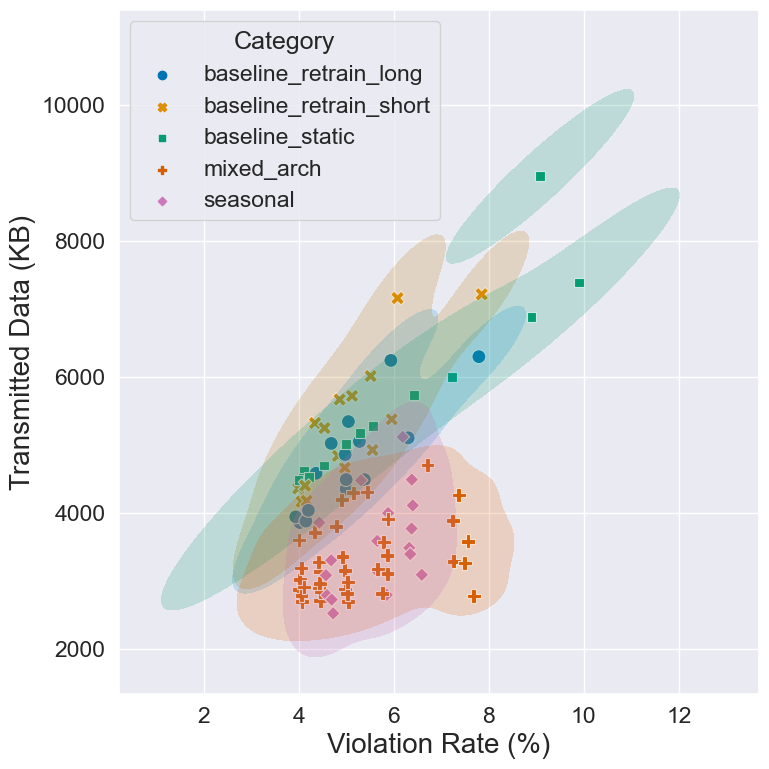

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = results.copy()
# df = df[df["strategy"] == "static"]
labels = {
    "comp_res_increase": "Computational resource usage increase (%)",
    "category": "Category",
    "total_data_kb": "Transmitted Data (KB)",
    "violation_rate": "Violation Rate (%)",
    "max_memory": "Max. Allocated Memory (MB)",
    "cpu_time_minutes": "CPU Time (min)",
}
df = df.rename(
    columns=labels
)

palette = sns.color_palette(palette="colorblind", n_colors=df["Category"].nunique())
category_colors = {cat: palette[i] for i, cat in enumerate(df['Category'].unique())}


def scatter_plot(
        df: pd.DataFrame,
        name: str,
        x_column: str,
        y_column: str,
        palette: dict,
        figsize: tuple = (8, 8),
):
    plt.figure(figsize=figsize)

    sns.set_context("notebook", font_scale=1.5)

    sns.scatterplot(
        data=df,
        x=x_column, y=y_column,
        # size=labels['comp_z_score'],
        hue='Category',
        style='Category',
        # sizes=(25, 500),
        s=100,
        palette=palette
    )

    for cat in df['Category'].unique():
        subset = df[df['Category'] == cat]
        sns.kdeplot(
            x=subset[x_column],
            y=subset[y_column],
            levels=2,
            fill=True,
            color=category_colors[cat],
            alpha=0.2,
            # bw_adjust=0.5
        )
        # points = df[df['Category'] == cat][[x_column, y_column]].values
        # if len(points) > 2:
        #     hull = ConvexHull(points)
        #     hull_points = points[hull.vertices]
        #     plt.fill(hull_points[:, 0], hull_points[:, 1], color=category_colors[cat], alpha=0.2, label=f"Hull {cat}")

    plt.tight_layout()
    plt.xlabel(x_column, fontsize=20)
    plt.ylabel(y_column, fontsize=20)

    plt.savefig(f"{analysis_folder}/{charts_folder}/{name}.png")
    plt.show()
    plt.close()


tmp = df[df['Category'] != 'baseline_static']
scatter_plot(df, "scatter_tx", labels['violation_rate'], labels['total_data_kb'], category_colors)

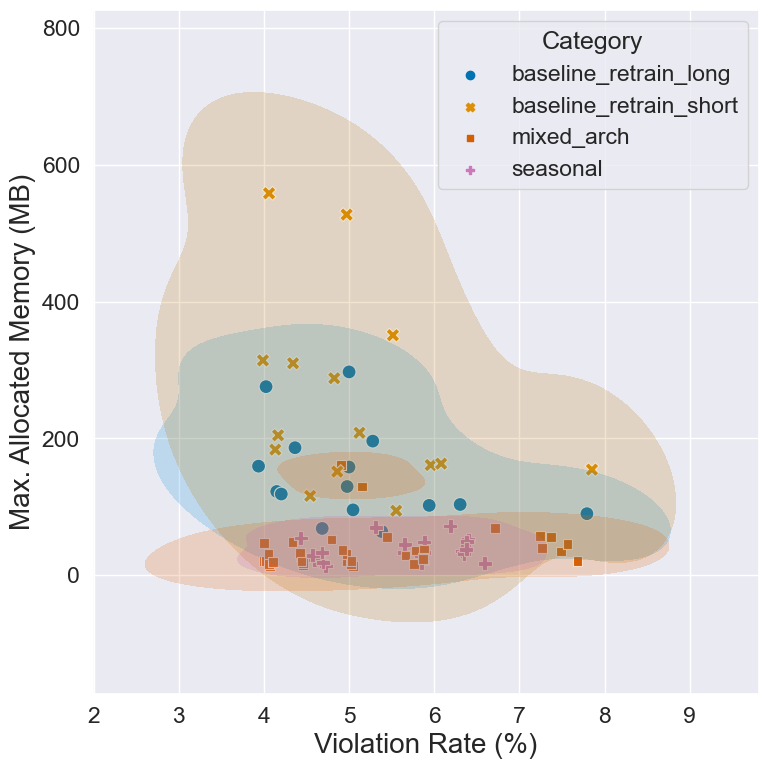

In [78]:
scatter_plot(tmp, "scatter_mem", labels['violation_rate'], labels['max_memory'], category_colors)

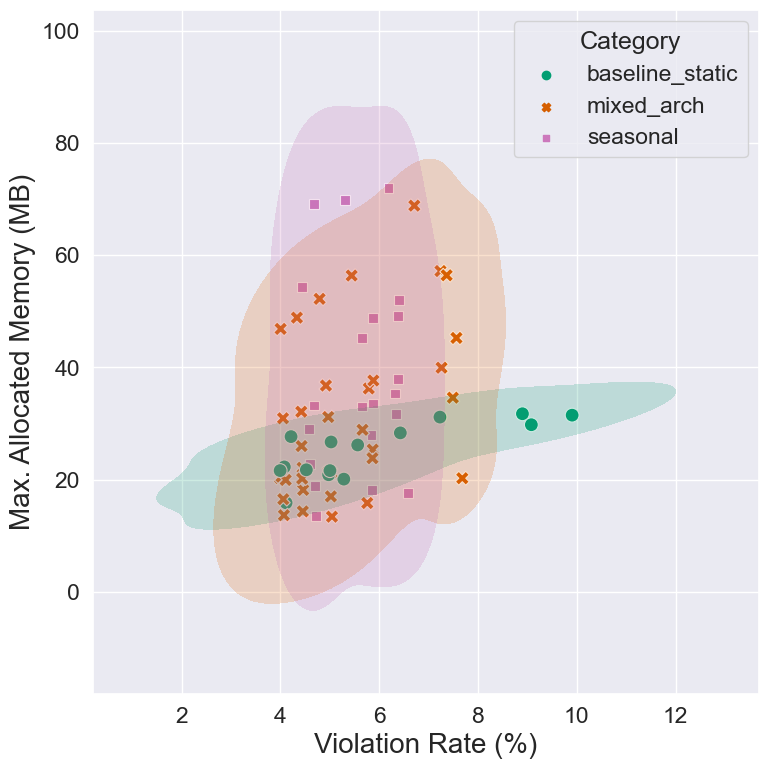

In [79]:
test = df[df['strategy'] == "static"]
scatter_plot(test, "scatter_mem_static", labels['violation_rate'], labels['max_memory'], category_colors)

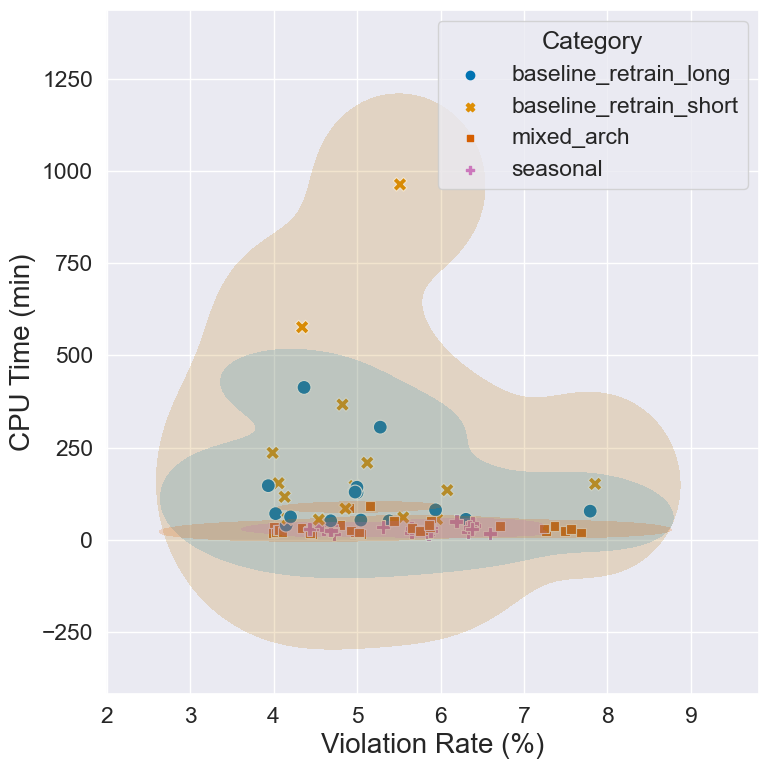

In [80]:
scatter_plot(tmp, "scatter_cpu", labels['violation_rate'], labels['cpu_time_minutes'], category_colors)

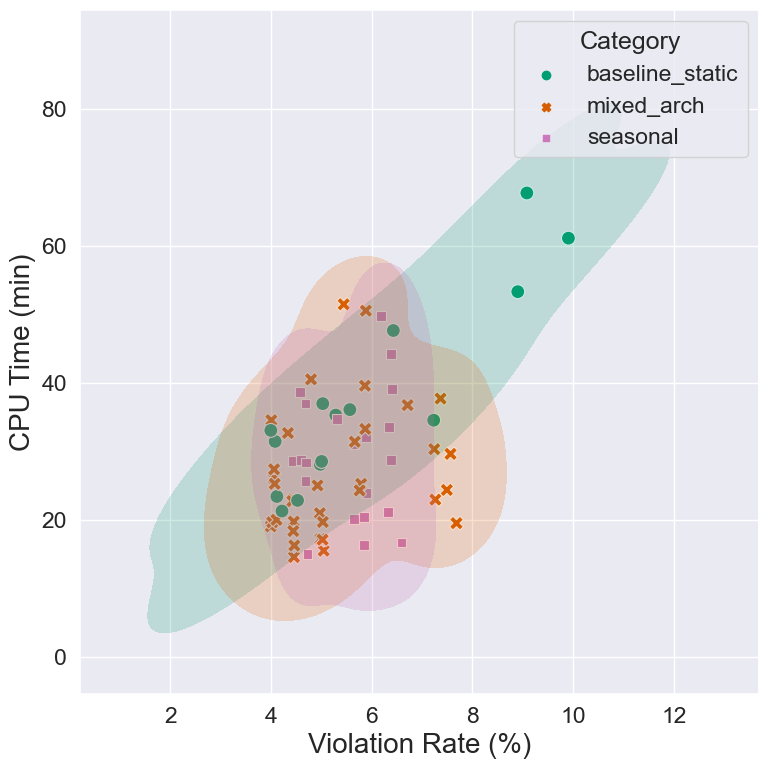

In [81]:
scatter_plot(test, "scatter_cpu_static", labels['violation_rate'], labels['cpu_time_minutes'], category_colors)

In [82]:
index_columns = ["category", "dataset", ]
rq1_columns = ["violation_rate", "rmse"]
rq2_columns = ["total_data_kb", "cpu_time_minutes", "max_memory"]

results_rq1_filtered = results[results['violation_threshold'] == '1v / 1h'][index_columns + rq1_columns]
results_rq2_filtered = results[results['violation_threshold'] == '1v / 1h'][index_columns + rq2_columns]

decimals = {
    'rmse': 4,
    'violation_rate': 1,
    'switch_rate': 1,
    'transmission_rate': 1,
    'cpu_time_minutes': 0,
    'max_memory': 1,
    'total_data_kb': 1,
}

results_rq1_filtered = results_rq1_filtered.round(decimals)
results_rq2_filtered = results_rq2_filtered.round(decimals)

results_rq1_worst: pd.DataFrame = results_rq1_filtered.groupby(['category', 'dataset']).agg(['max'])
results_rq1_best: pd.DataFrame = results_rq1_filtered.groupby(['category', 'dataset']).agg(['min'])
results_rq1_avg: pd.DataFrame = results_rq1_filtered.groupby(['category', 'dataset']).agg(['mean'])
results_rq1_combined = results_rq1_best.join(results_rq1_worst).join(results_rq1_avg)

results_rq1_combined.columns = ["_".join(col) for col in results_rq1_combined.columns]
results_rq1_combined = results_rq1_combined.reindex(columns=sorted(results_rq1_combined.columns))

results_rq1_combined

rmse_max  rmse_mean  rmse_min  \
category               dataset                                           
baseline_retrain_long  linz_2010_2019      0.5487   0.546733    0.5442   
                       linz_2019_2019      0.5880   0.570867    0.5518   
                       vienna_2010_2019    0.5326   0.526033    0.5206   
                       vienna_2017_2019    0.5388   0.530533    0.5236   
                       vienna_2019_2019    0.5613   0.548933    0.5392   
baseline_retrain_short linz_2010_2019      0.5562   0.546433    0.5402   
                       linz_2019_2019      0.5916   0.571733    0.5539   
                       vienna_2010_2019    0.5293   0.524133    0.5201   
                       vienna_2017_2019    0.5470   0.533933    0.5267   
                       vienna_2019_2019    0.5618   0.548300    0.5369   
baseline_static        linz_2010_2019      0.5466   0.545100    0.5438   
                       linz_2019_2019      0.6179   0.605800    0.5845   
                       vienna_2010_2019    0.5245   0.523133    0.5214   
                       vienna_2017_2019    0.5397   0.533833    0.5272   
                       vienna_2019_2019    0.6035   0.578333    0.5578   
mixed_arch             linz_2010_2019      0.5365   0.536500    0.5365   
                       linz_2019_2019      0.5688   0.568800    0.5688   
                       vienna_2010_2019    0.5221   0.522100    0.5221   
                       vienna_2017_2019    0.5259   0.525900    0.5259   
                       vienna_2019_2019    0.5465   0.541833    0.5367   
seasonal               vienna_2017_2019    0.5488   0.541467    0.5310   

                                         violation_rate_max  \
category               dataset                                
baseline_retrain_long  linz_2010_2019                   5.3   
                       linz_2019_2019                   7.8   
                       vienna_2010_2019                 4.4   
                       vienna_2017_2019                 5.0   
                       vienna_2019_2019                 5.9   
baseline_retrain_short linz_2010_2019                   5.5   
                       linz_2019_2019                   7.9   
                       vienna_2010_2019                 4.3   
                       vienna_2017_2019                 5.1   
                       vienna_2019_2019                 6.1   
baseline_static        linz_2010_2019                   5.3   
                       linz_2019_2019                   9.9   
                       vienna_2010_2019                 4.1   
                       vienna_2017_2019                 5.0   
                       vienna_2019_2019                 9.1   
mixed_arch             linz_2010_2019                   4.8   
                       linz_2019_2019                   6.7   
                       vienna_2010_2019                 4.0   
                       vienna_2017_2019                 4.3   
                       vienna_2019_2019                 5.4   
seasonal               vienna_2017_2019                 6.2   

                                         violation_rate_mean  \
category               dataset                                 
baseline_retrain_long  linz_2010_2019               5.100000   
                       linz_2019_2019               6.500000   
                       vienna_2010_2019             4.100000   
                       vienna_2017_2019             4.466667   
                       vienna_2019_2019             5.200000   
baseline_retrain_short linz_2010_2019               5.100000   
                       linz_2019_2019               6.500000   
                       vienna_2010_2019             4.133333   
                       vienna_2017_2019             4.466667   
                       vienna_2019_2019             5.166667   
baseline_static        linz_2010_2019               5.100000   
                       linz_2019_2019               8.66

In [83]:
results_rq2_filtered = results_rq2_filtered.round(decimals)

results_rq2_worst: pd.DataFrame = results_rq2_filtered.groupby(['category', 'dataset']).agg(['max'])
results_rq2_best: pd.DataFrame = results_rq2_filtered.groupby(['category', 'dataset']).agg(['min'])
results_rq2_avg: pd.DataFrame = results_rq2_filtered.groupby(['category', 'dataset']).agg(['mean'])
results_rq2_combined = results_rq2_best.join(results_rq2_worst).join(results_rq2_avg)

results_rq2_combined.columns = ["_".join(col) for col in results_rq2_combined.columns]
results_rq2_combined = results_rq2_combined.reindex(columns=sorted(results_rq2_combined.columns))

results_rq2_combined

cpu_time_minutes_max  \
category               dataset                                  
baseline_retrain_long  linz_2010_2019                   305.0   
                       linz_2019_2019                    77.0   
                       vienna_2010_2019                 413.0   
                       vienna_2017_2019                 129.0   
                       vienna_2019_2019                  81.0   
baseline_retrain_short linz_2010_2019                   964.0   
                       linz_2019_2019                   151.0   
                       vienna_2010_2019                 577.0   
                       vienna_2017_2019                 209.0   
                       vienna_2019_2019                 134.0   
baseline_static        linz_2010_2019                    37.0   
                       linz_2019_2019                    61.0   
                       vienna_2010_2019                  33.0   
                       vienna_2017_2019                  28.0   
                       vienna_2019_2019                  68.0   
mixed_arch             linz_2010_2019                    40.0   
                       linz_2019_2019                    37.0   
                       vienna_2010_2019                  35.0   
                       vienna_2017_2019                  33.0   
                       vienna_2019_2019                  91.0   
seasonal               vienna_2017_2019                  50.0   

                                         cpu_time_minutes_mean  \
category               dataset                                   
baseline_retrain_long  linz_2010_2019               191.666667   
                       linz_2019_2019                61.000000   
                       vienna_2010_2019             210.333333   
                       vienna_2017_2019              77.000000   
                       vienna_2019_2019              61.666667   
baseline_retrain_short linz_2010_2019               492.000000   
                       linz_2019_2019                89.000000   
                       vienna_2010_2019             322.000000   
                       vienna_2017_2019             127.333333   
                       vienna_2019_2019              90.666667   
baseline_static        linz_2010_2019                33.333333   
                       linz_2019_2019                49.666667   
                       vienna_2010_2019              29.000000   
                       vienna_2017_2019              24.000000   
                       vienna_2019_2019              50.666667   
mixed_arch             linz_2010_2019                40.000000   
                       linz_2019_2019                37.000000   
                       vienna_2010_2019              35.000000   
                       vienna_2017_2019              33.000000   
                       vienna_2019_2019              76.333333   
seasonal               vienna_2017_2019              38.000000   

                                         cpu_time_minutes_min  max_memory_max  \
category               dataset                                                  
baseline_retrain_long  linz_2010_2019                   128.0           297.4   
                       linz_2019_2019                    51.0           103.5   
                       vienna_2010_2019                  71.0           275.8   
                       vienna_2017_2019                  40.0           129.8   
                       vienna_2019_2019                  51.0           102.2   
baseline_retrain_short linz_2010_2019                   145.0           527.4   
                       linz_2019_2019                    56.0           161.2   
                       vienna_2010_2019                 153.0           558.6   
                       vienna_2017_2019                  57.0           208.5   
                       vienna_2019_2019                  54.0           163.2   
baseline_static        linz_2010_2019                 

In [84]:
def save_latex_table(
        results: pd.DataFrame,
        name: str,
        hide_index: bool = False,
        rounding: dict = None,
        add_percentage: bool = False,
) -> None:
    df = results.copy()

    if rounding is not None:
        for col, decimals in rounding.items():
            if col in df.columns:
                df[col] = df[col].apply(lambda x: f"{x:.{decimals}f}%" if add_percentage else f"{x:.{decimals}f}")

    styler = df.style.format(escape='latex')
    styler.format_index(escape="latex", axis=1)

    if hide_index:
        styler.hide(axis="index")

    latex_code = styler.to_latex()

    path = f"{analysis_folder}/{name}.tex"
    print(f"💾 Saving results as LaTeX table {path}")
    with open(path, "w") as f:
        f.write(latex_code)


def get_pivot(
        df: pd.DataFrame,
        baseline_category: str,
        interesting_categories: list[str],
        use_percentages: bool = True
) -> pd.DataFrame:
    pivot_df = df.copy()
    baseline_values: pd.Series = pivot_df.loc[baseline_category]
    result_df = pivot_df.loc[interesting_categories]
    diff_df = (result_df - baseline_values)
    if use_percentages:
        diff_df = diff_df / baseline_values * 100

    return diff_df


def combine_pivots(source: pd.DataFrame, use_percentage: bool = True) -> pd.DataFrame:
    interesting_categories = ['mixed_arch', 'seasonal']
    baseline_categories = ["baseline_static", "baseline_retrain_short", "baseline_retrain_long"]
    result: pd.DataFrame | None = None
    for i, baseline in enumerate(baseline_categories):
        pivot = get_pivot(
            source, baseline, interesting_categories, use_percentage
        )
        pivot.columns = sorted(pivot.columns)
        pivot.columns = [col + f"_{baseline}" for col in pivot.columns]
        if result is None:
            result = pivot
        else:
            result = result.join(pivot)
    if use_percentage:
        decimals = {col: 1 for col in result.columns}
        result = result.round(decimals)
    return result


rq1_print_columns = [
    "portfolio", "strategy", "violation_threshold",
    "rmse", "violation_rate",
]
rq2_print_columns = [
    "portfolio", "strategy", "violation_threshold",
    "max_memory", "cpu_time_minutes", "total_data_kb"
]
static_results: pd.DataFrame = results[results['strategy'] == 'static']
static_results = static_results.sort_values(by=['portfolio', 'violation_threshold'], ascending=True)

retrain_results: pd.DataFrame = results[results['strategy'] != 'static']
retrain_results = retrain_results.sort_values(by=['portfolio', 'strategy'], ascending=True)

save_latex_table(static_results[rq1_print_columns], "results_rq1_static", hide_index=True, rounding=decimals)
save_latex_table(static_results[rq2_print_columns], "results_rq2_static", hide_index=True, rounding=decimals)
save_latex_table(retrain_results[rq1_print_columns], "results_rq1_retrain", hide_index=True, rounding=decimals)
save_latex_table(retrain_results[rq2_print_columns], "results_rq2_retrain", hide_index=True, rounding=decimals)

💾 Saving results as LaTeX table analysis/results_rq1_static.tex
💾 Saving results as LaTeX table analysis/results_rq2_static.tex
💾 Saving results as LaTeX table analysis/results_rq1_retrain.tex
💾 Saving results as LaTeX table analysis/results_rq2_retrain.tex


In [85]:
violation_rate_df = results_rq1_combined[["violation_rate_min", "violation_rate_max"]]
violation_rate_df

violation_rate_min  \
category               dataset                                
baseline_retrain_long  linz_2010_2019                   5.0   
                       linz_2019_2019                   5.4   
                       vienna_2010_2019                 3.9   
                       vienna_2017_2019                 4.2   
                       vienna_2019_2019                 4.7   
baseline_retrain_short linz_2010_2019                   4.8   
                       linz_2019_2019                   5.6   
                       vienna_2010_2019                 4.0   
                       vienna_2017_2019                 4.1   
                       vienna_2019_2019                 4.5   
baseline_static        linz_2010_2019                   5.0   
                       linz_2019_2019                   7.2   
                       vienna_2010_2019                 4.0   
                       vienna_2017_2019                 4.2   
                       vienna_2019_2019                 5.6   
mixed_arch             linz_2010_2019                   4.8   
                       linz_2019_2019                   6.7   
                       vienna_2010_2019                 4.0   
                       vienna_2017_2019                 4.3   
                       vienna_2019_2019                 4.9   
seasonal               vienna_2017_2019                 4.4   

                                         violation_rate_max  
category               dataset                               
baseline_retrain_long  linz_2010_2019                   5.3  
                       linz_2019_2019                   7.8  
                       vienna_2010_2019                 4.4  
                       vienna_2017_2019                 5.0  
                       vienna_2019_2019                 5.9  
baseline_retrain_short linz_2010_2019                   5.5  
                       linz_2019_2019                   7.9  
                       vienna_2010_2019                 4.3  
                       vienna_2017_2019                 5.1  
                       vienna_2019_2019                 6.1  
baseline_static        linz_2010_2019                   5.3  
                       linz_2019_2019                   9.9  
                       vienna_2010_2019                 4.1  
                       vienna_2017_2019                 5.0  
                       vienna_2019_2019                 9.1  
mixed_arch             linz_2010_2019                   4.8  
                       linz_2019_2019                   6.7  
                       vienna_2010_2019                 4.0  
                       vienna_2017_2019                 4.3  
                       vienna_2019_2019                 5.4  
seasonal               vienna_2017_2019                 6.2

In [86]:
violation_rate_pivot = combine_pivots(violation_rate_df, False)
save_latex_table(
    violation_rate_pivot, "results_pivot_violation_rate",
    rounding={col: 1 for col in violation_rate_pivot.columns}
)
violation_rate_pivot

💾 Saving results as LaTeX table analysis/results_pivot_violation_rate.tex


violation_rate_max_baseline_static  \
category   dataset                                                
mixed_arch linz_2010_2019                                  -0.2   
           linz_2019_2019                                  -0.5   
           vienna_2010_2019                                 0.0   
           vienna_2017_2019                                 0.1   
           vienna_2019_2019                                -0.7   
seasonal   vienna_2017_2019                                 0.2   

                             violation_rate_min_baseline_static  \
category   dataset                                                
mixed_arch linz_2010_2019                                  -0.5   
           linz_2019_2019                                  -3.2   
           vienna_2010_2019                                -0.1   
           vienna_2017_2019                                -0.7   
           vienna_2019_2019                                -3.7   
seasonal   vienna_2017_2019                                 1.2   

                             violation_rate_max_baseline_retrain_short  \
category   dataset                                                       
mixed_arch linz_2010_2019                                          0.0   
           linz_2019_2019                                          1.1   
           vienna_2010_2019                                        0.0   
           vienna_2017_2019                                        0.2   
           vienna_2019_2019                                        0.4   
seasonal   vienna_2017_2019                                        0.3   

                             violation_rate_min_baseline_retrain_short  \
category   dataset                                                       
mixed_arch linz_2010_2019                                         -0.7   
           linz_2019_2019                                         -1.2   
           vienna_2010_2019                                       -0.3   
           vienna_2017_2019                                       -0.8   
           vienna_2019_2019                                       -0.7   
seasonal   vienna_2017_2019                                        1.1   

                             violation_rate_max_baseline_retrain_long  \
category   dataset                                                      
mixed_arch linz_2010_2019                                        -0.2   
           linz_2019_2019                                         1.3   
           vienna_2010_2019                                       0.1   
           vienna_2017_2019                                       0.1   
           vienna_2019_2019                                       0.2   
seasonal   vienna_2017_2019                                       0.2   

                             violation_rate_min_baseline_retrain_long  
category   dataset                                                     
mixed_arch linz_2010_2019                                        -0.5  
           linz_2019_2019                                        -1.1  
           vienna_2010_2019                                      -0.4  
           vienna_2017_2019                                      -0.7  
           vienna_2019_2019                                      -0.5  
seasonal   vienna_2017_2019                                       1.2

In [87]:
rmse_df = results_rq1_combined[["rmse_min", "rmse_max"]]
rmse_df

rmse_min  rmse_max
category               dataset                             
baseline_retrain_long  linz_2010_2019      0.5442    0.5487
                       linz_2019_2019      0.5518    0.5880
                       vienna_2010_2019    0.5206    0.5326
                       vienna_2017_2019    0.5236    0.5388
                       vienna_2019_2019    0.5392    0.5613
baseline_retrain_short linz_2010_2019      0.5402    0.5562
                       linz_2019_2019      0.5539    0.5916
                       vienna_2010_2019    0.5201    0.5293
                       vienna_2017_2019    0.5267    0.5470
                       vienna_2019_2019    0.5369    0.5618
baseline_static        linz_2010_2019      0.5438    0.5466
                       linz_2019_2019      0.5845    0.6179
                       vienna_2010_2019    0.5214    0.5245
                       vienna_2017_2019    0.5272    0.5397
                       vienna_2019_2019    0.5578    0.6035
mixed_arch             linz_2010_2019      0.5365    0.5365
                       linz_2019_2019      0.5688    0.5688
                       vienna_2010_2019    0.5221    0.5221
                       vienna_2017_2019    0.5259    0.5259
                       vienna_2019_2019    0.5367    0.5465
seasonal               vienna_2017_2019    0.5310    0.5488

In [88]:
rmse_pivot = combine_pivots(rmse_df)
save_latex_table(
    rmse_pivot, "results_pivot_rmse",
    rounding={col: 1 for col in rmse_pivot.columns}
)
rmse_pivot

💾 Saving results as LaTeX table analysis/results_pivot_rmse.tex


rmse_max_baseline_static  \
category   dataset                                      
mixed_arch linz_2010_2019                        -1.3   
           linz_2019_2019                        -2.7   
           vienna_2010_2019                       0.1   
           vienna_2017_2019                      -0.2   
           vienna_2019_2019                      -3.8   
seasonal   vienna_2017_2019                       0.7   

                             rmse_min_baseline_static  \
category   dataset                                      
mixed_arch linz_2010_2019                        -1.8   
           linz_2019_2019                        -7.9   
           vienna_2010_2019                      -0.5   
           vienna_2017_2019                      -2.6   
           vienna_2019_2019                      -9.4   
seasonal   vienna_2017_2019                       1.7   

                             rmse_max_baseline_retrain_short  \
category   dataset                                             
mixed_arch linz_2010_2019                               -0.7   
           linz_2019_2019                                2.7   
           vienna_2010_2019                              0.4   
           vienna_2017_2019                             -0.2   
           vienna_2019_2019                             -0.0   
seasonal   vienna_2017_2019                              0.8   

                             rmse_min_baseline_retrain_short  \
category   dataset                                             
mixed_arch linz_2010_2019                               -3.5   
           linz_2019_2019                               -3.9   
           vienna_2010_2019                             -1.4   
           vienna_2017_2019                             -3.9   
           vienna_2019_2019                             -2.7   
seasonal   vienna_2017_2019                              0.3   

                             rmse_max_baseline_retrain_long  \
category   dataset                                            
mixed_arch linz_2010_2019                              -1.4   
           linz_2019_2019                               3.1   
           vienna_2010_2019                             0.3   
           vienna_2017_2019                             0.4   
           vienna_2019_2019                            -0.5   
seasonal   vienna_2017_2019                             1.4   

                             rmse_min_baseline_retrain_long  
category   dataset                                           
mixed_arch linz_2010_2019                              -2.2  
           linz_2019_2019                              -3.3  
           vienna_2010_2019                            -2.0  
           vienna_2017_2019                            -2.4  
           vienna_2019_2019                            -2.6  
seasonal   vienna_2017_2019                             1.9

In [89]:
cpu_df = results_rq2_combined[["cpu_time_minutes_min", "cpu_time_minutes_max"]]
cpu_df

cpu_time_minutes_min  \
category               dataset                                  
baseline_retrain_long  linz_2010_2019                   128.0   
                       linz_2019_2019                    51.0   
                       vienna_2010_2019                  71.0   
                       vienna_2017_2019                  40.0   
                       vienna_2019_2019                  51.0   
baseline_retrain_short linz_2010_2019                   145.0   
                       linz_2019_2019                    56.0   
                       vienna_2010_2019                 153.0   
                       vienna_2017_2019                  57.0   
                       vienna_2019_2019                  54.0   
baseline_static        linz_2010_2019                    28.0   
                       linz_2019_2019                    35.0   
                       vienna_2010_2019                  23.0   
                       vienna_2017_2019                  21.0   
                       vienna_2019_2019                  36.0   
mixed_arch             linz_2010_2019                    40.0   
                       linz_2019_2019                    37.0   
                       vienna_2010_2019                  35.0   
                       vienna_2017_2019                  33.0   
                       vienna_2019_2019                  51.0   
seasonal               vienna_2017_2019                  29.0   

                                         cpu_time_minutes_max  
category               dataset                                 
baseline_retrain_long  linz_2010_2019                   305.0  
                       linz_2019_2019                    77.0  
                       vienna_2010_2019                 413.0  
                       vienna_2017_2019                 129.0  
                       vienna_2019_2019                  81.0  
baseline_retrain_short linz_2010_2019                   964.0  
                       linz_2019_2019                   151.0  
                       vienna_2010_2019                 577.0  
                       vienna_2017_2019                 209.0  
                       vienna_2019_2019                 134.0  
baseline_static        linz_2010_2019                    37.0  
                       linz_2019_2019                    61.0  
                       vienna_2010_2019                  33.0  
                       vienna_2017_2019                  28.0  
                       vienna_2019_2019                  68.0  
mixed_arch             linz_2010_2019                    40.0  
                       linz_2019_2019                    37.0  
                       vienna_2010_2019                  35.0  
                       vienna_2017_2019                  33.0  
                       vienna_2019_2019                  91.0  
seasonal               vienna_2017_2019                  50.0

In [90]:
cpu_pivot = combine_pivots(cpu_df)
save_latex_table(
    cpu_pivot, "results_pivot_cpu",
    rounding={col: 1 for col in cpu_pivot.columns}
)
cpu_pivot

💾 Saving results as LaTeX table analysis/results_pivot_cpu.tex


cpu_time_minutes_max_baseline_static  \
category   dataset                                                  
mixed_arch linz_2010_2019                                    42.9   
           linz_2019_2019                                     5.7   
           vienna_2010_2019                                  52.2   
           vienna_2017_2019                                  57.1   
           vienna_2019_2019                                  41.7   
seasonal   vienna_2017_2019                                  38.1   

                             cpu_time_minutes_min_baseline_static  \
category   dataset                                                  
mixed_arch linz_2010_2019                                     8.1   
           linz_2019_2019                                   -39.3   
           vienna_2010_2019                                   6.1   
           vienna_2017_2019                                  17.9   
           vienna_2019_2019                                  33.8   
seasonal   vienna_2017_2019                                  78.6   

                             cpu_time_minutes_max_baseline_retrain_short  \
category   dataset                                                         
mixed_arch linz_2010_2019                                          -72.4   
           linz_2019_2019                                          -33.9   
           vienna_2010_2019                                        -77.1   
           vienna_2017_2019                                        -42.1   
           vienna_2019_2019                                         -5.6   
seasonal   vienna_2017_2019                                        -49.1   

                             cpu_time_minutes_min_baseline_retrain_short  \
category   dataset                                                         
mixed_arch linz_2010_2019                                          -95.9   
           linz_2019_2019                                          -75.5   
           vienna_2010_2019                                        -93.9   
           vienna_2017_2019                                        -84.2   
           vienna_2019_2019                                        -32.1   
seasonal   vienna_2017_2019                                        -76.1   

                             cpu_time_minutes_max_baseline_retrain_long  \
category   dataset                                                        
mixed_arch linz_2010_2019                                         -68.8   
           linz_2019_2019                                         -27.5   
           vienna_2010_2019                                       -50.7   
           vienna_2017_2019                                       -17.5   
           vienna_2019_2019                                         0.0   
seasonal   vienna_2017_2019                                       -27.5   

                             cpu_time_minutes_min_baseline_retrain_long  
category   dataset                                                       
mixed_arch linz_2010_2019                                         -86.9  
           linz_2019_2019                                         -51.9  
           vienna_2010_2019                                       -91.5  
           vienna_2017_2019                                       -74.4  
           vienna_2019_2019                                        12.3  
seasonal   vienna_2017_2019                                       -61.2

In [91]:
mem_df = results_rq2_combined[["max_memory_min", "max_memory_max"]]
mem_df

max_memory_min  max_memory_max
category               dataset                                         
baseline_retrain_long  linz_2010_2019             158.2           297.4
                       linz_2019_2019              63.9           103.5
                       vienna_2010_2019           159.5           275.8
                       vienna_2017_2019           118.8           129.8
                       vienna_2019_2019            68.4           102.2
baseline_retrain_short linz_2010_2019             288.1           527.4
                       linz_2019_2019              94.4           161.2
                       vienna_2010_2019           310.1           558.6
                       vienna_2017_2019           183.7           208.5
                       vienna_2019_2019           116.0           163.2
baseline_static        linz_2010_2019              20.1            26.7
                       linz_2019_2019              31.2            31.8
                       vienna_2010_2019            15.9            22.3
                       vienna_2017_2019            21.6            27.7
                       vienna_2019_2019            26.2            29.8
mixed_arch             linz_2010_2019              52.2            52.2
                       linz_2019_2019              68.9            68.9
                       vienna_2010_2019            46.9            46.9
                       vienna_2017_2019            48.9            48.9
                       vienna_2019_2019            56.4           161.8
seasonal               vienna_2017_2019            54.4            72.0

In [92]:
mem_pivot = combine_pivots(mem_df)
save_latex_table(
    mem_pivot, "results_pivot_mem",
    rounding={col: 1 for col in mem_pivot.columns}
)
mem_pivot

💾 Saving results as LaTeX table analysis/results_pivot_mem.tex


max_memory_max_baseline_static  \
category   dataset                                            
mixed_arch linz_2010_2019                             159.7   
           linz_2019_2019                             120.8   
           vienna_2010_2019                           195.0   
           vienna_2017_2019                           126.4   
           vienna_2019_2019                           115.3   
seasonal   vienna_2017_2019                           151.9   

                             max_memory_min_baseline_static  \
category   dataset                                            
mixed_arch linz_2010_2019                              95.5   
           linz_2019_2019                             116.7   
           vienna_2010_2019                           110.3   
           vienna_2017_2019                            76.5   
           vienna_2019_2019                           443.0   
seasonal   vienna_2017_2019                           159.9   

                             max_memory_max_baseline_retrain_short  \
category   dataset                                                   
mixed_arch linz_2010_2019                                    -81.9   
           linz_2019_2019                                    -27.0   
           vienna_2010_2019                                  -84.9   
           vienna_2017_2019                                  -73.4   
           vienna_2019_2019                                  -51.4   
seasonal   vienna_2017_2019                                  -70.4   

                             max_memory_min_baseline_retrain_short  \
category   dataset                                                   
mixed_arch linz_2010_2019                                    -90.1   
           linz_2019_2019                                    -57.3   
           vienna_2010_2019                                  -91.6   
           vienna_2017_2019                                  -76.5   
           vienna_2019_2019                                   -0.9   
seasonal   vienna_2017_2019                                  -65.5   

                             max_memory_max_baseline_retrain_long  \
category   dataset                                                  
mixed_arch linz_2010_2019                                   -67.0   
           linz_2019_2019                                     7.8   
           vienna_2010_2019                                 -70.6   
           vienna_2017_2019                                 -58.8   
           vienna_2019_2019                                 -17.5   
seasonal   vienna_2017_2019                                 -54.2   

                             max_memory_min_baseline_retrain_long  
category   dataset                                                 
mixed_arch linz_2010_2019                                   -82.4  
           linz_2019_2019                                   -33.4  
           vienna_2010_2019                                 -83.0  
           vienna_2017_2019                                 -62.3  
           vienna_2019_2019                                  58.3  
seasonal   vienna_2017_2019                                 -44.5

In [93]:
tx_df = results_rq2_combined[["total_data_kb_min", "total_data_kb_max"]]
tx_df

total_data_kb_min  total_data_kb_max
category               dataset                                               
baseline_retrain_long  linz_2010_2019               4354.8             5054.1
                       linz_2019_2019               4493.4             6300.9
                       vienna_2010_2019             3861.6             4585.9
                       vienna_2017_2019             3882.7             4861.8
                       vienna_2019_2019             5025.7             6246.1
baseline_retrain_short linz_2010_2019               4668.6             6015.8
                       linz_2019_2019               4928.6             7218.1
                       vienna_2010_2019             4168.7             5325.0
                       vienna_2017_2019             4181.8             5723.9
                       vienna_2019_2019             5251.4             7162.1
baseline_static        linz_2010_2019               4958.3             5179.0
                       linz_2019_2019               6005.7             7391.2
                       vienna_2010_2019             4489.4             4625.4
                       vienna_2017_2019             4534.8             5011.6
                       vienna_2019_2019             5277.7             8952.4
mixed_arch             linz_2010_2019               3807.2             3807.2
                       linz_2019_2019               4707.6             4707.6
                       vienna_2010_2019             3606.7             3606.7
                       vienna_2017_2019             3717.5             3717.5
                       vienna_2019_2019             4197.3             4313.4
seasonal               vienna_2017_2019             3860.8             5120.8

In [94]:
tx_pivot = combine_pivots(tx_df)
save_latex_table(
    tx_pivot, "results_pivot_tx",
    rounding={col: 1 for col in tx_pivot.columns}
)
tx_pivot

💾 Saving results as LaTeX table analysis/results_pivot_tx.tex


total_data_kb_max_baseline_static  \
category   dataset                                               
mixed_arch linz_2010_2019                                -23.2   
           linz_2019_2019                                -21.6   
           vienna_2010_2019                              -19.7   
           vienna_2017_2019                              -18.0   
           vienna_2019_2019                              -20.5   
seasonal   vienna_2017_2019                              -14.9   

                             total_data_kb_min_baseline_static  \
category   dataset                                               
mixed_arch linz_2010_2019                                -26.5   
           linz_2019_2019                                -36.3   
           vienna_2010_2019                              -22.0   
           vienna_2017_2019                              -25.8   
           vienna_2019_2019                              -51.8   
seasonal   vienna_2017_2019                                2.2   

                             total_data_kb_max_baseline_retrain_short  \
category   dataset                                                      
mixed_arch linz_2010_2019                                       -18.5   
           linz_2019_2019                                        -4.5   
           vienna_2010_2019                                     -13.5   
           vienna_2017_2019                                     -11.1   
           vienna_2019_2019                                     -20.1   
seasonal   vienna_2017_2019                                      -7.7   

                             total_data_kb_min_baseline_retrain_short  \
category   dataset                                                      
mixed_arch linz_2010_2019                                       -36.7   
           linz_2019_2019                                       -34.8   
           vienna_2010_2019                                     -32.3   
           vienna_2017_2019                                     -35.1   
           vienna_2019_2019                                     -39.8   
seasonal   vienna_2017_2019                                     -10.5   

                             total_data_kb_max_baseline_retrain_long  \
category   dataset                                                     
mixed_arch linz_2010_2019                                      -12.6   
           linz_2019_2019                                        4.8   
           vienna_2010_2019                                     -6.6   
           vienna_2017_2019                                     -4.3   
           vienna_2019_2019                                    -16.5   
seasonal   vienna_2017_2019                                     -0.6   

                             total_data_kb_min_baseline_retrain_long  
category   dataset                                                    
mixed_arch linz_2010_2019                                      -24.7  
           linz_2019_2019                                      -25.3  
           vienna_2010_2019                                    -21.4  
           vienna_2017_2019                                    -23.5  
           vienna_2019_2019                                    -30.9  
seasonal   vienna_2017_2019                                      5.3

In [95]:

import pandas as pd


class Subplot:
    def __init__(
            self,
            x_data_column: str,
            y_data_column: str,
            y_label: str,
    ):
        self.x_data_column = x_data_column
        self.y_data_column = y_data_column
        self.y_label = y_label


def create_color_mappings(column: str) -> dict:
    all_x_values = sorted(set(results[column].unique()))
    palette = sns.color_palette("colorblind", len(all_x_values))
    return {category: palette[i] for i, category in enumerate(all_x_values)}


def draw_plot(
        df: pd.DataFrame,
        x_data_column: str,
        y_data_column: str,
        y_label: str,
        group_by: str,
        color_mappings: dict,
        subfolder: str,
        name: str,
        title: str = "",
        width: float = 0.5,
        height: float = 5,
        aspect: float = 0.5,
):
    order = df.groupby([x_data_column])[y_data_column].median().sort_values(ascending=True).index

    col_wrap = min(5, len(df[group_by].unique()))

    g = sns.catplot(
        data=df,
        x=x_data_column,
        y=y_data_column,
        col=group_by,
        kind="box",
        col_wrap=col_wrap,
        legend=False,
        palette=color_mappings,
        width=width,
        height=height,
        aspect=aspect,
        order=order,
    )
    g.set_axis_labels("", y_label)
    g.set_titles("{col_name}")

    for ax in g.axes.flat:
        # ax.set_ylim(df[y_data_column].min() * 0.95, df[y_data_column].max() * 1.05)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha='right', rotation_mode="anchor")

    path: str = os.path.join(analysis_folder, charts_folder, subfolder, name + ".png")

    # g.map(sns.boxplot, x_data_column, y_data_column, order=order, width=0.4)
    g.figure.suptitle(title, fontsize=16, fontweight='bold')
    g.savefig(path, format='png', bbox_inches='tight')
    g.tight_layout()
    plt.show()
    plt.close()


import os
import pandas as pd
import seaborn as sns


def draw_subplots(
        df: pd.DataFrame,
        subplots: list[Subplot],
        subfolder: str,
        name: str,
        color_mappings: dict,
        title: str = "",
        width: float = 4,
        height: float = 6,
):
    size = len(subplots)
    cols = min(size, 4)
    rows = int(size / cols) if size % cols == 0 else (size // cols) + 1
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * width, rows * height))

    if size == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(size):
        ax = axes[i]
        subplot = subplots[i]
        y_column = subplot.y_data_column
        x_column = subplot.x_data_column

        order = df.groupby([x_column])[y_column].median().sort_values(ascending=True).index

        sns.boxplot(
            data=df,
            x=x_column,
            y=y_column,
            palette=color_mappings,
            order=order,
            ax=ax,
            width=0.4
        )

        ax.set_title(title)
        ax.set_xlabel("")
        ax.set_ylabel(subplot.y_label)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha='right', rotation_mode='anchor')

        # y_min = df[y_column].min() * 0.95
        # y_max = df[y_column].max() * 1.05
        # ax.set_ylim(y_min, y_max)

    for j in range(size, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    path: str = os.path.join(analysis_folder, charts_folder, subfolder, name + ".png")
    fig.savefig(path, format='png', bbox_inches='tight')

    plt.show()
    plt.close()


architecture_colors = create_color_mappings("architecture")
dataset_colors = create_color_mappings("dataset_group")
violation_limit_colors = create_color_mappings("violation_threshold")
category_colors = create_color_mappings("category")


### RQ1

In [96]:
subfolder = "rq1"

In [97]:
columns = ['portfolio', 'strategy', 'rmse', 'violation_rate']

d2 = (results[(results["strategy"] == "static") & (results["violation_threshold"] == "1v / 1h")]
      .sort_values(by="rmse"))

save_latex_table(d2[columns], "mixed")

d2

💾 Saving results as LaTeX table analysis/mixed.tex


,portfolio,strategy,violation_threshold,rmse,violation_rate,mallocs,max_memory,cpu_time,data_sent,data_received,...,start_year,end_year,dataset,architecture,dataset_group,category,cpu_time_minutes,cpu_increase,mem_increase,comp_res_increase
47,vienna_2010_2019_simple_lstm,static,1v / 1h,0.521401,3.994718,190399,21.624,1981.578,3418019.0,1071415.0,...,2010,2019,vienna_2010_2019,simple_lstm,vienna_2010_2019,baseline_static,33.026300,1.271759,0.613852,1.885611
35,vienna_2010_2019_mixed_arch,static,1v / 1h,0.522060,4.005168,691495,46.883,2070.812,2862128.0,744576.0,...,2010,2019,vienna_2010_2019,mixed_arch,vienna_2010_2019,mixed_arch,34.513533,1.374060,2.498992,3.873053
34,vienna_2010_2019_conv_lstm,static,1v / 1h,0.523520,4.115367,172708,15.874,1402.766,3448320.0,1177060.0,...,2010,2019,vienna_2010_2019,conv_lstm,vienna_2010_2019,baseline_static,23.379433,0.608186,0.184715,0.792901
44,vienna_2010_2019_simple_dense,static,1v / 1h,0.524456,4.080217,183967,22.272,1885.172,3445366.0,1068788.0,...,2010,2019,vienna_2010_2019,simple_dense,vienna_2010_2019,baseline_static,31.419533,1.161235,0.662214,1.823449
58,vienna_2017_2019_mixed_arch,static,1v / 1h,0.525871,4.334815,732202,48.887,1958.891,2919188.0,798284.0,...,2017,2019,vienna_2017_2019,mixed_arch,vienna_2017_2019,mixed_arch,32.648183,1.245750,2.648556,3.894305
74,vienna_2017_2019_simple_dense,static,1v / 1h,0.527169,4.216066,262356,27.678,1275.453,3460129.0,1074694.0,...,2017,2019,vienna_2017_2019,simple_dense,vienna_2017_2019,baseline_static,21.257550,0.462229,1.065677,1.527906
67,vienna_2017_2019_simple_dense_seasons,static,1v / 1h,0.531017,4.432665,859366,54.372,1714.953,2982489.0,878267.0,...,2017,2019,vienna_2017_2019,simple_dense,seasonal,seasonal,28.582550,0.966089,3.057915,4.024004
57,vienna_2017_2019_conv_lstm,static,1v / 1h,0.534590,5.003610,244766,21.615,1709.859,3642614.0,1369010.0,...,2017,2019,vienna_2017_2019,conv_lstm,vienna_2017_2019,baseline_static,28.497650,0.960250,0.613180,1.573430
3,linz_2010_2019_mixed_arch,static,1v / 1h,0.536456,4.793662,739528,52.245,2428.969,2952704.0,854490.0,...,2010,2019,linz_2010_2019,mixed_arch,linz_2010_2019,mixed_arch,40.482817,1.784665,2.899172,4.683837
84,vienna_2017_2019_simple_lstm,static,1v / 1h,0.539694,4.525764,241540,21.757,1368.703,3528423.0,1173664.0,...,2017,2019,vienna_2017_2019,simple_lstm,vienna_2017_2019,baseline_static,22.811717,0.569135,0.623778,1.192913


In [98]:
df = results[["category", "dataset", "rmse", "violation_rate"]]
df: pd.DataFrame = df.groupby(["dataset", "category"])[["rmse", "violation_rate"]].min()
df = df.sort_values(by=["dataset", "violation_rate"], ascending=True)
df

rmse  violation_rate
dataset          category                                        
linz_2010_2019   mixed_arch              0.536456        4.793662
                 baseline_retrain_short  0.540203        4.825961
                 baseline_static         0.543758        4.977010
                 baseline_retrain_long   0.544173        4.998860
linz_2019_2019   baseline_retrain_long   0.551832        5.383607
                 baseline_retrain_short  0.553881        5.553656
                 mixed_arch              0.568828        6.711696
                 baseline_static         0.584492        7.230392
vienna_2010_2019 baseline_retrain_long   0.520592        3.936769
                 baseline_retrain_short  0.520071        3.989018
                 baseline_static         0.521401        3.994718
                 mixed_arch              0.521628        3.996618
vienna_2017_2019 baseline_retrain_short  0.526683        4.133417
                 baseline_retrain_long   0.523562        4.150517
                 baseline_static         0.527169        4.216066
                 mixed_arch              0.525871        4.334815
                 seasonal                0.531017        4.432665
vienna_2019_2019 baseline_retrain_short  0.536909        4.542864
                 baseline_retrain_long   0.539230        4.684413
                 mixed_arch              0.536679        4.902911
                 baseline_static         0.557817        5.565055

In [99]:
save_latex_table(df, "mixed_arch", rounding=decimals)

💾 Saving results as LaTeX table analysis/mixed_arch.tex


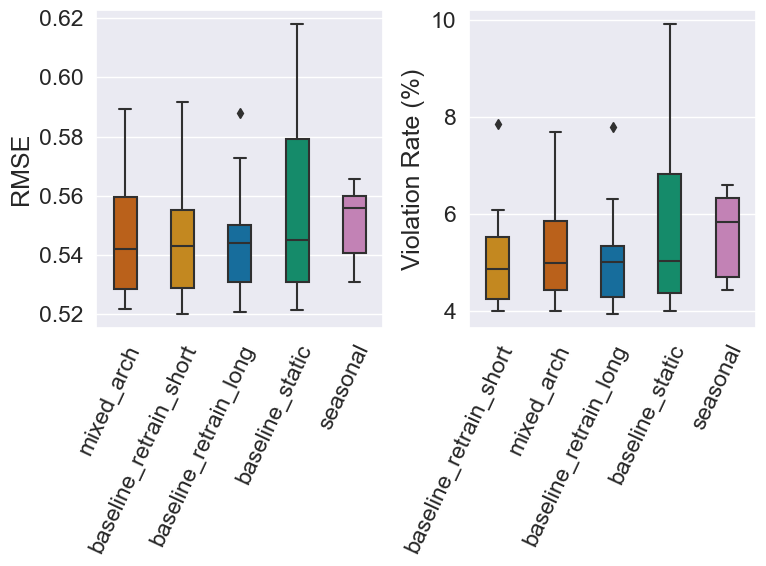

In [100]:
df = results

rmse = Subplot(x_data_column="category", y_data_column="rmse", y_label="RMSE")
violation_rate = Subplot(x_data_column="category", y_data_column="violation_rate", y_label="Violation Rate (%)")

draw_subplots(df=df, subplots=[rmse, violation_rate], name="effectiveness_category", color_mappings=category_colors,
              subfolder=subfolder, width=4)

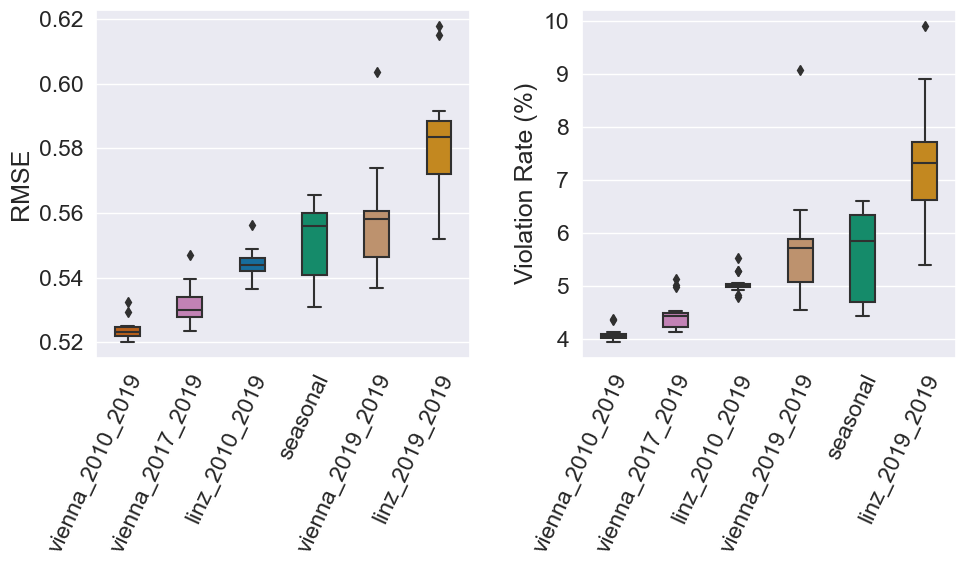

In [101]:
df = results
# [(results["architecture"] != "mixed_arch")]

rmse = Subplot(x_data_column="dataset_group", y_data_column="rmse", y_label="RMSE")
violation_rate = Subplot(x_data_column="dataset_group", y_data_column="violation_rate", y_label="Violation Rate (%)")

draw_subplots(df=df, subplots=[rmse, violation_rate], subfolder=subfolder, name="effectiveness_dataset",
              color_mappings=dataset_colors, width=5)

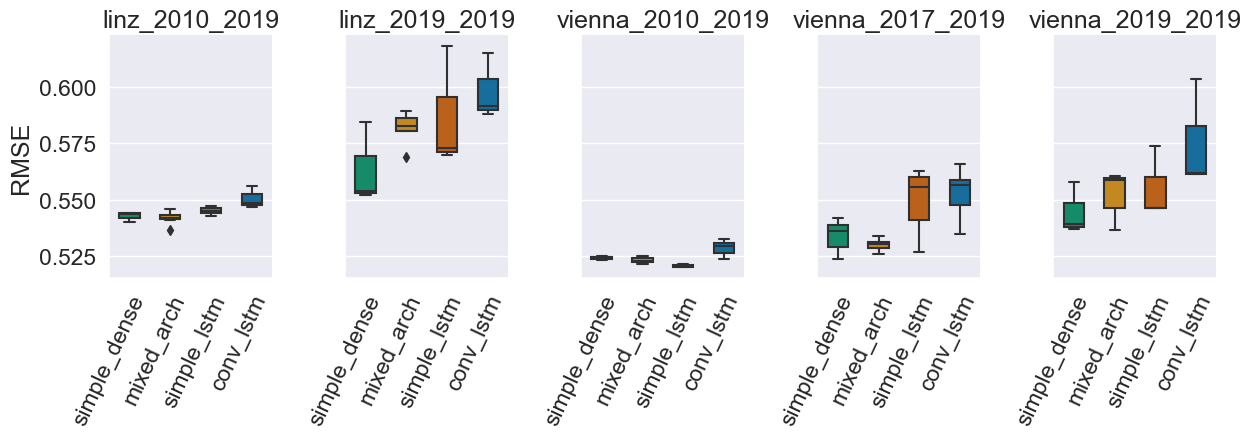

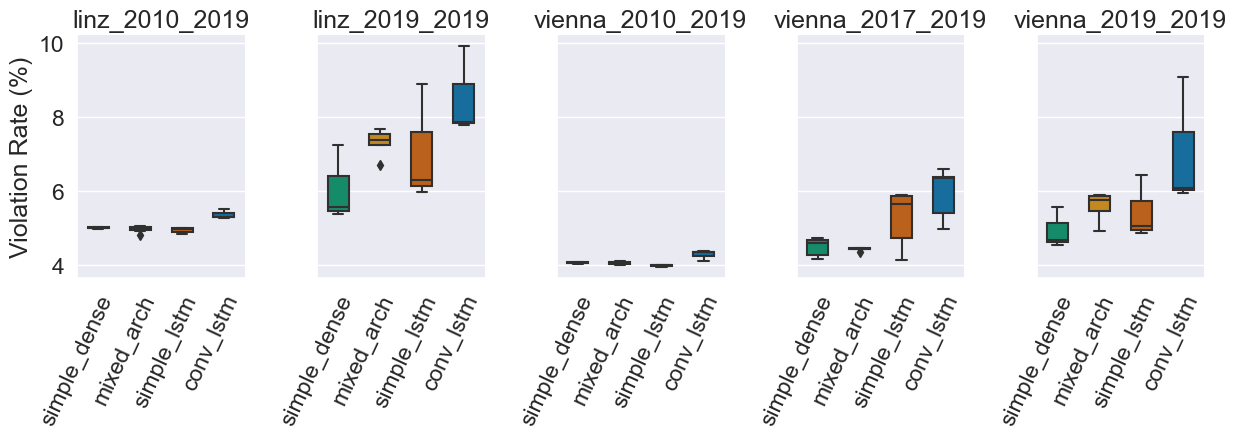

In [102]:
df = results
# [(results["seasons"] == False)]

draw_plot(df=df, x_data_column="architecture", y_data_column="rmse", y_label="RMSE", group_by="dataset",
          color_mappings=architecture_colors, subfolder=subfolder, name="rmse_architecture", )
draw_plot(df=df, x_data_column="architecture", y_data_column="violation_rate", y_label="Violation Rate (%)",
          group_by="dataset", color_mappings=architecture_colors, subfolder=subfolder,
          name="violation_rate_architecture", )

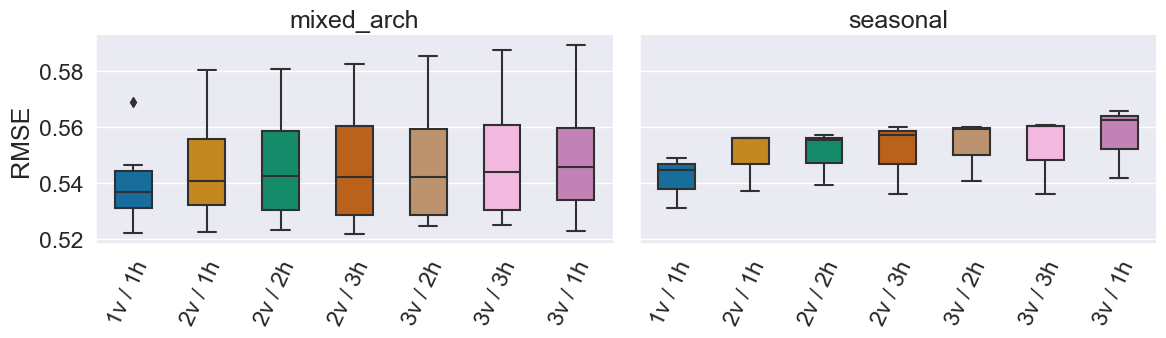

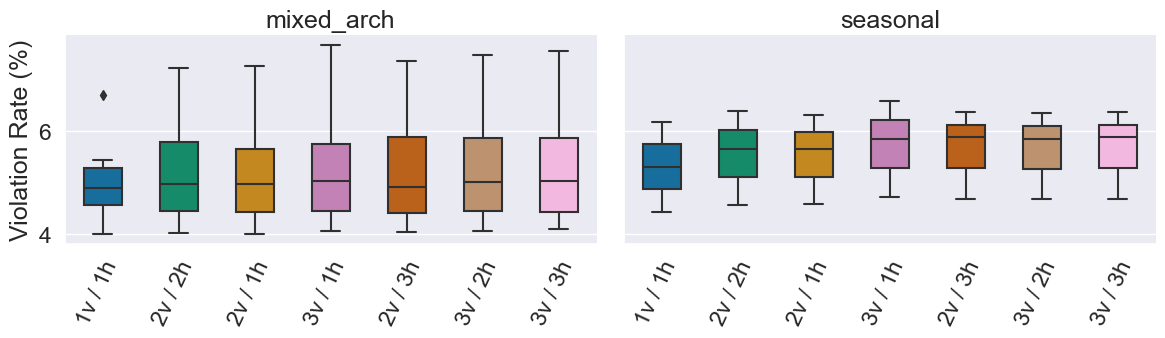

In [103]:
df = results[(results["seasons"] == True) | (results["architecture"] == "mixed_arch")]

draw_plot(df=df, x_data_column="violation_threshold", y_data_column="rmse", y_label="RMSE", group_by="category",
          width=0.5, height=4, aspect=1.5, color_mappings=violation_limit_colors, subfolder=subfolder,
          name="rmse_sensitivity_category", )
draw_plot(df=df, x_data_column="violation_threshold", y_data_column="violation_rate", y_label="Violation Rate (%)",
          group_by="category", width=0.5, height=4, aspect=1.5, color_mappings=violation_limit_colors,
          subfolder=subfolder, name="violation_rate_sensitivity_category", )

### RQ 2

In [114]:
subfolder = "rq2"

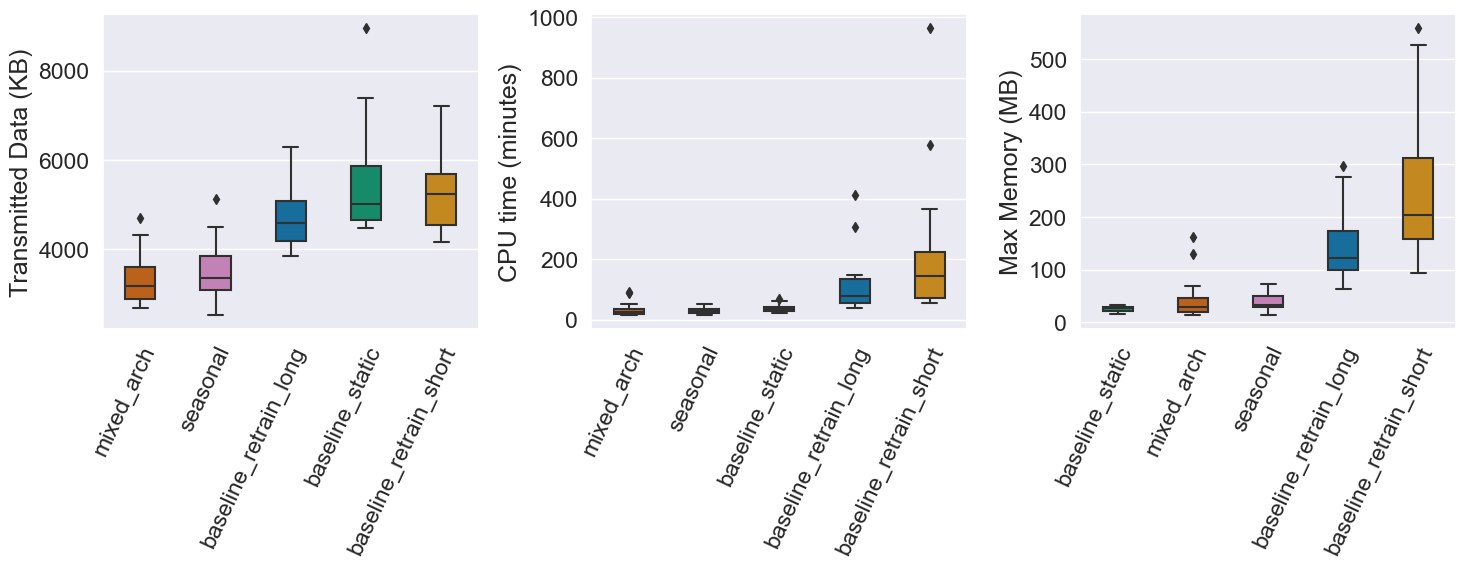

In [115]:
df = results

cpu = Subplot(x_data_column="category", y_data_column="cpu_time_minutes", y_label="CPU time (minutes)")
memory = Subplot(x_data_column="category", y_data_column="max_memory", y_label="Max Memory (MB)")
# mallocs = Subplot(x_data_column="category", y_data_column="mallocs_k", y_label="Mallocs (thousands)")
data = Subplot(x_data_column="category", y_data_column="total_data_kb", y_label="Transmitted Data (KB)")

draw_subplots(df=df, subplots=[data, cpu, memory], subfolder=subfolder, name="efficiency_category",
              color_mappings=category_colors, width=5)

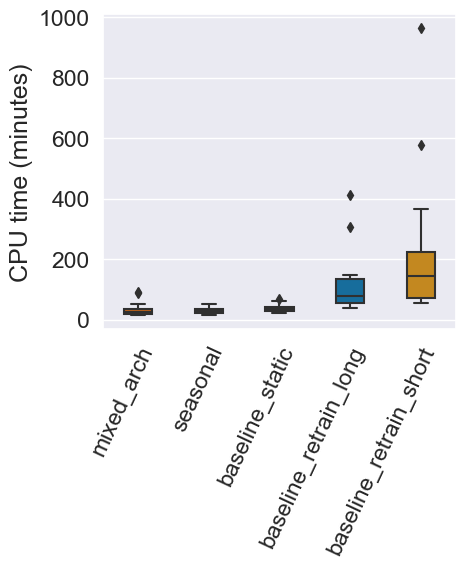

In [117]:
draw_subplots(df=df, subplots=[cpu], subfolder=subfolder, name="efficiency_category_cpu",
              color_mappings=category_colors, width=5)

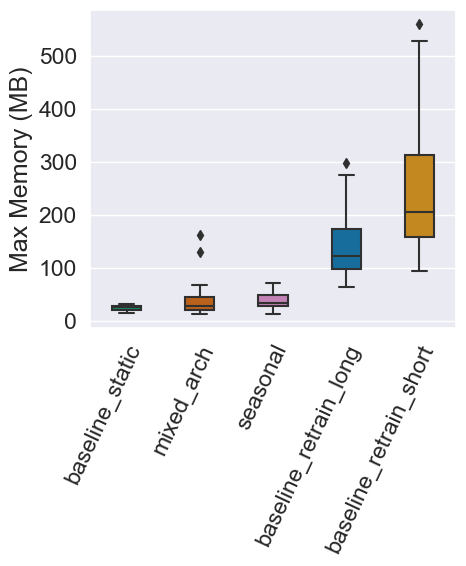

In [119]:
draw_subplots(df=df, subplots=[memory], subfolder=subfolder, name="efficiency_category_mem",
              color_mappings=category_colors, width=5)

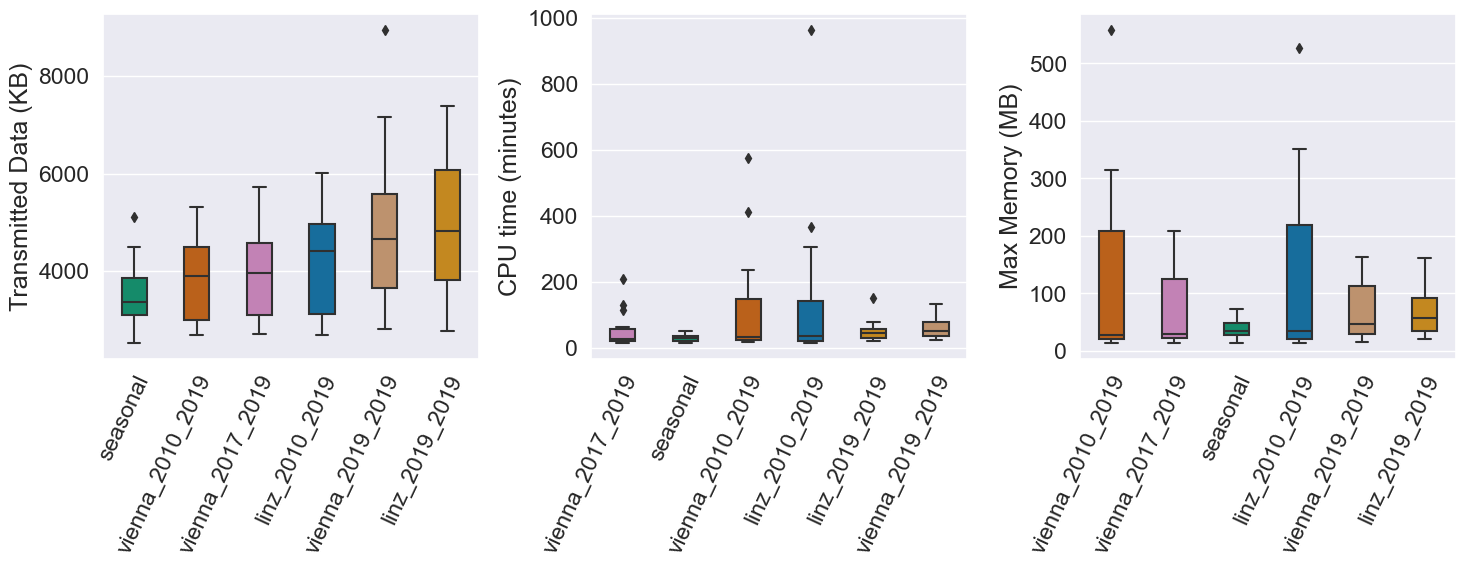

In [107]:
df = results
# [
# (results["architecture"] != "mixed_arch")
# & (results["strategy"] == "retrain_short")
# (results["seasons"] == False)
# ]
cpu = Subplot(x_data_column="dataset_group", y_data_column="cpu_time_minutes", y_label="CPU time (minutes)")
memory = Subplot(x_data_column="dataset_group", y_data_column="max_memory", y_label="Max Memory (MB)")
# mallocs = Subplot(x_data_column="dataset_group", y_data_column="mallocs_k", y_label="Mallocs (thousands)")
data = Subplot(x_data_column="dataset_group", y_data_column="total_data_kb", y_label="Transmitted Data (KB)")

draw_subplots(df=df, subplots=[data, cpu, memory], subfolder=subfolder, name="efficiency_dataset",
              color_mappings=dataset_colors, width=5)

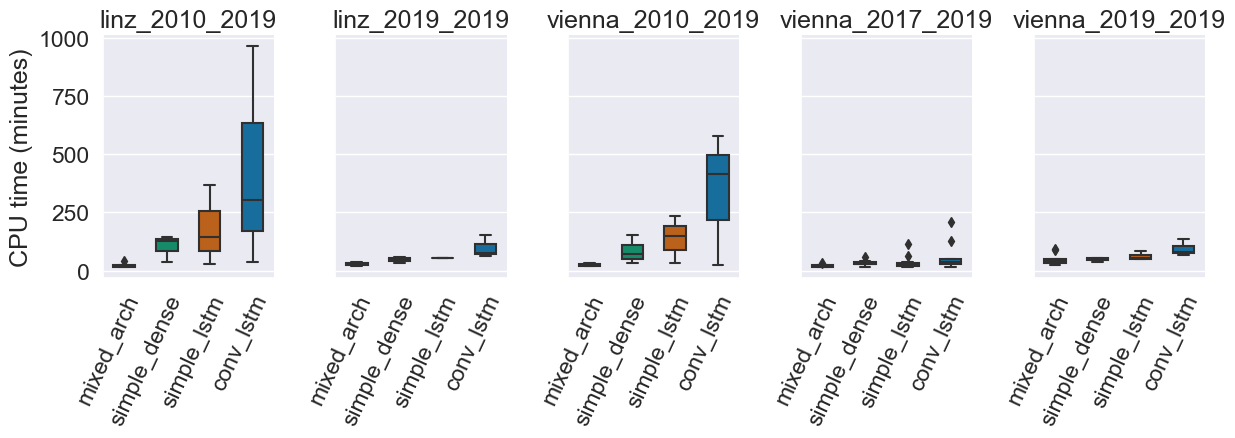

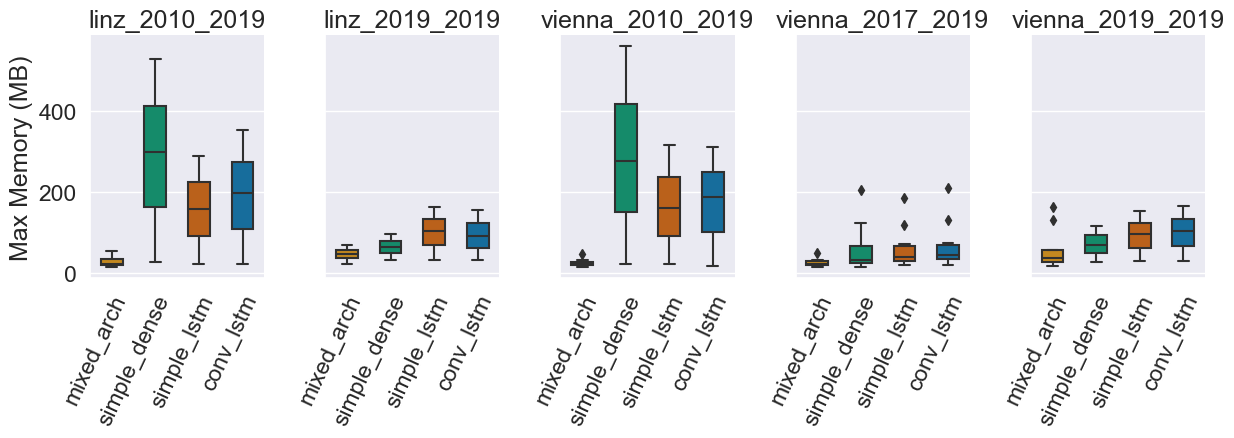

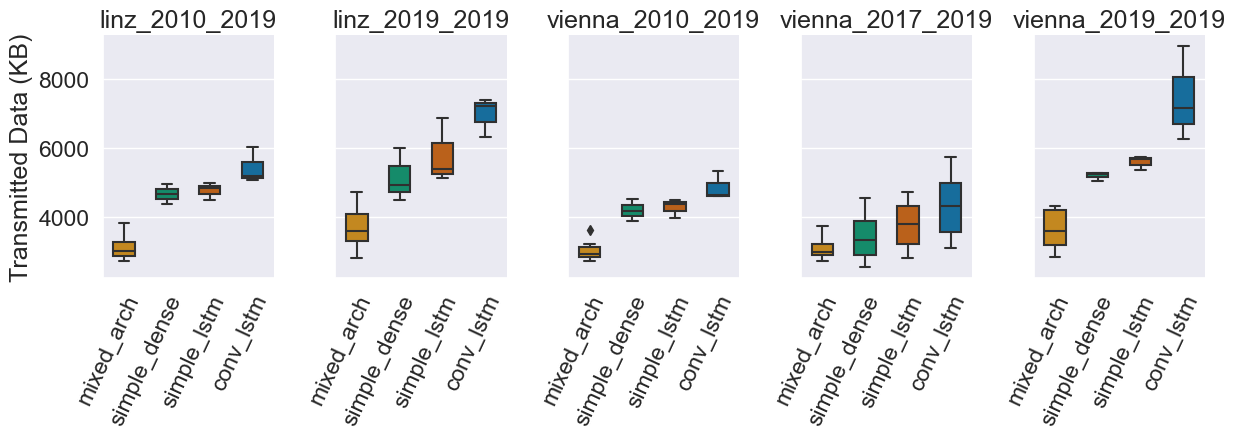

In [108]:
df = results
# [
# (results["seasons"] == False)
# & (results["strategy"] == "static")
# ]

draw_plot(df=df, x_data_column="architecture", y_data_column="cpu_time_minutes", y_label="CPU time (minutes)",
          group_by="dataset", color_mappings=architecture_colors, subfolder=subfolder, name="cpu_arch", )
draw_plot(df=df, x_data_column="architecture", y_data_column="max_memory", y_label="Max Memory (MB)",
          group_by="dataset", color_mappings=architecture_colors, subfolder=subfolder, name="memory_arch", )
# draw_catplot(df=df, x_data_column="architecture", y_data_column="mallocs_k", y_label="Mallocs (thousands)",
#              group_by="dataset", color_mappings=architecture_colors, name="mallocs_arch", )
draw_plot(df=df, x_data_column="architecture", y_data_column="total_data_kb", y_label="Transmitted Data (KB)",
          group_by="dataset", color_mappings=architecture_colors, subfolder=subfolder, name="transmitted_data_arch", )

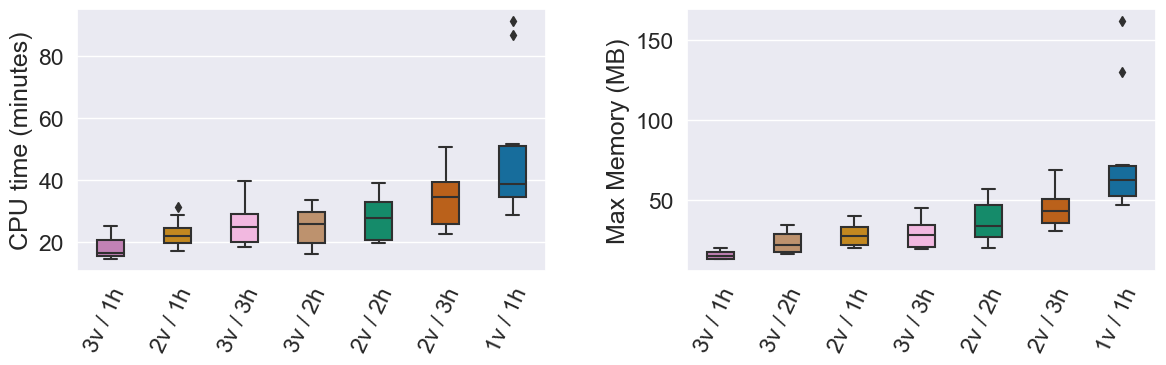

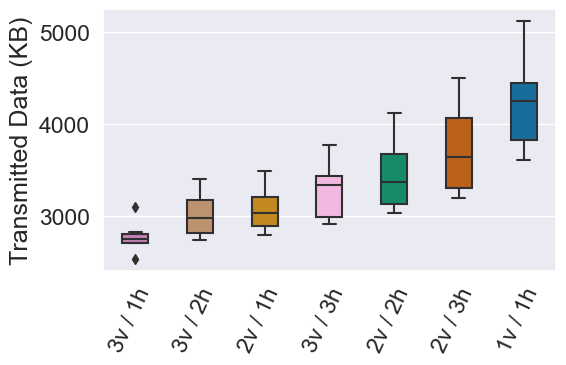

In [109]:
df = results[(results["seasons"] == True) | (results["architecture"] == "mixed_arch")]

cpu = Subplot(x_data_column="violation_threshold", y_data_column="cpu_time_minutes", y_label="CPU time (minutes)")
memory = Subplot(x_data_column="violation_threshold", y_data_column="max_memory", y_label="Max Memory (MB)")
data = Subplot(x_data_column="violation_threshold", y_data_column="total_data_kb", y_label="Transmitted Data (KB)")

draw_subplots(df=df, subplots=[cpu, memory], subfolder=subfolder, name="efficiency_comp_sensitivity",
              color_mappings=violation_limit_colors, width=6, height=4)
draw_subplots(df=df, subplots=[data], subfolder=subfolder, name="efficiency_data_sensitivity",
              color_mappings=violation_limit_colors, width=6, height=4)

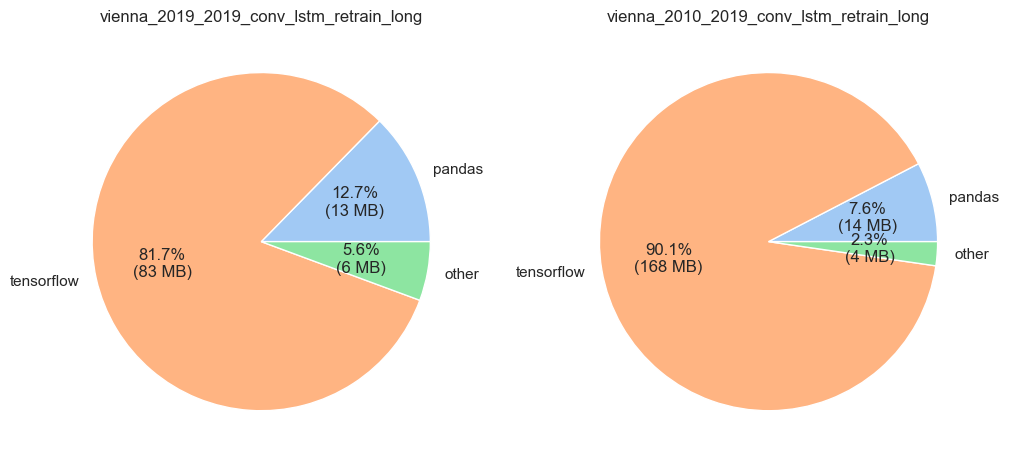

In [110]:
def load_mem_usage(file: str) -> pd.DataFrame:
    memory_usage = pd.read_csv(file, index_col=0)

    def extract_module(traceback: str) -> str:
        tokens = traceback.split("\\")
        modules = ["tensorflow", "pandas", "keras", "numpy"]

        return next((t for t in tokens if t in modules), 'other')

    memory_usage["module"] = memory_usage["traceback"].apply(lambda x: extract_module(x))
    return memory_usage


def pie_label(pct: float, values: pd.DataFrame) -> str:
    absolute = int(round(pct / 100. * sum(values)))
    return f"{pct:.1f}%\n({absolute} MB)"


def plot_pies(memory_df: list[pd.DataFrame], titles: list[str]):
    sns.set_theme(style="darkgrid")
    threshold = 0.01

    num_pies = len(memory_df)
    cols = min(num_pies, 3)
    rows = (num_pies + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))

    if num_pies > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Itera sulla lista dei dati per ogni torta
    for i, data in enumerate(memory_df):
        data_grouped = data.groupby('module')['size_megabytes'].sum()

        total = data_grouped.sum()
        data_percent = data_grouped / total

        data_filtered = data_grouped[(data_percent >= threshold) & (data_grouped.index != "other")]
        other_size = data_grouped[(data_percent < threshold) | (data_grouped.index == "other")].sum()

        if other_size > 0:
            other = pd.Series({'other': other_size})
            data_filtered = pd.concat([data_filtered, other])

        axes[i].pie(
            data_filtered,
            labels=data_filtered.index,
            autopct=lambda pct: pie_label(pct, data_filtered),
            colors=sns.color_palette("pastel")
        )
        axes[i].set_title(titles[i])

    for j in range(num_pies, len(axes)):
        axes[j].axis('off')

    plt.show()
    plt.close()


small_conv_lstm_retrain_long = load_mem_usage(
    "simulations/vienna_2019_2019_conv_lstm_retrain_long_1v1h/memory_snapshot.csv")
conv_lstm_retrain_short = load_mem_usage(
    "simulations/vienna_2019_2019_conv_lstm_retrain_short_1v1h/memory_snapshot.csv")
conv_lstm_static = load_mem_usage("simulations/vienna_2019_2019_conv_lstm_static_1v1h/memory_snapshot.csv")
big_conv_lstm_static = load_mem_usage("simulations/vienna_2010_2019_conv_lstm_static_1v1h/memory_snapshot.csv")
big_conv_lstm_retrain = load_mem_usage("simulations/vienna_2010_2019_conv_lstm_retrain_long_1v1h/memory_snapshot.csv")

mixed_static = load_mem_usage("simulations/vienna_2010_2019_simple_dense_static_1v1h/memory_snapshot.csv")
mixed_retrain = load_mem_usage("simulations/vienna_2010_2019_simple_dense_retrain_short_1v1h/memory_snapshot.csv")

plot_pies([small_conv_lstm_retrain_long, big_conv_lstm_retrain],
          ["vienna_2019_2019_conv_lstm_retrain_long", "vienna_2010_2019_conv_lstm_retrain_long"])